
# Support Vector Machine


## Initialization: courtesy of Tove

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SequentialFeatureSelector  # RFE only works for linear SVM
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


plt.style.use("seaborn-v0_8-colorblind")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path

from cleanup import removeRows


In [14]:
data_processor = removeRows("../project_train.csv")
data_processor.process_rows();
data = data_processor.df


Row 85 will be removed:
danceability          0.7050
energy              734.0000
key                   1.0000
loudness             -4.5510
mode                  0.0000
speechiness           0.0775
acousticness          0.2850
instrumentalness      0.0000
liveness              0.0480
valence               0.9630
tempo               157.9920
Label                 1.0000
Name: 84, dtype: float64

Row 95 will be removed:
danceability          0.276000
energy                0.715000
key                   0.000000
loudness             -5.356000
mode                  1.000000
speechiness           0.043200
acousticness          0.005520
instrumentalness      0.000417
liveness              0.201000
valence               0.173000
tempo               137.028000
Label                 1.000000
Name: 95, dtype: float64


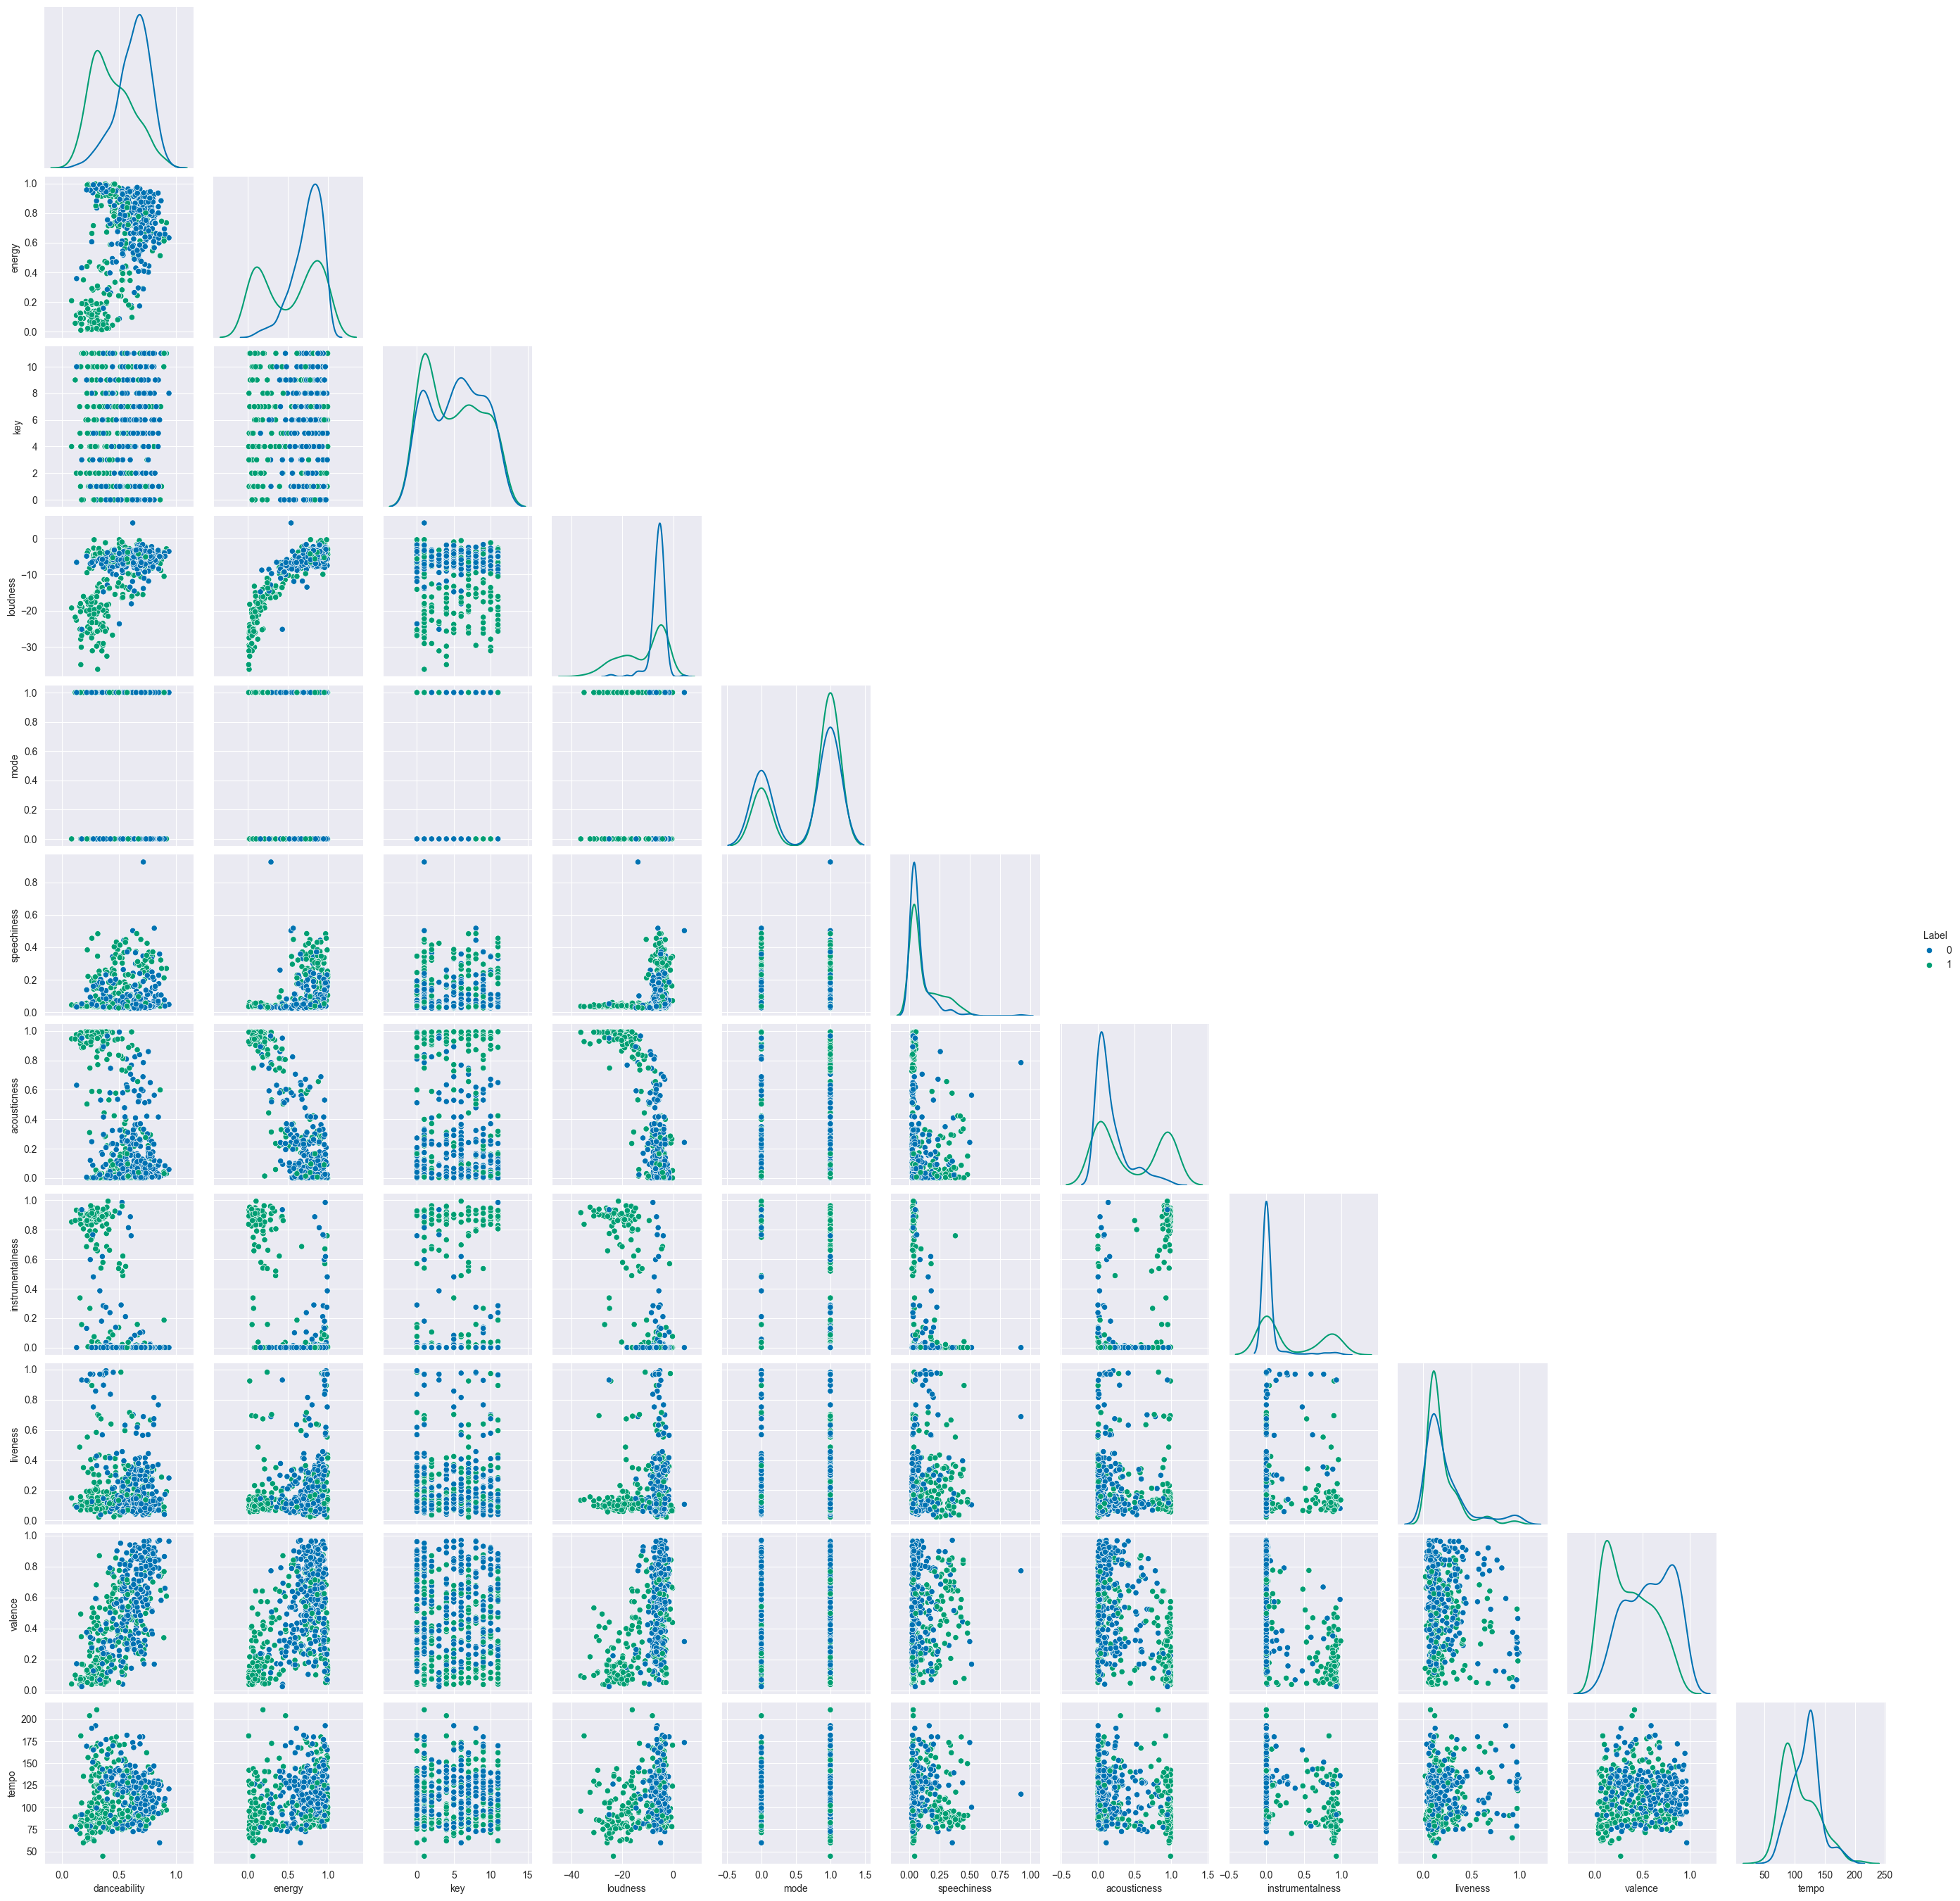

In [17]:
# Create the pairplot with scatter plots for off-diagonal and probability distributions (KDE) on diagonal
sns.pairplot(data, hue = "Label", diag_kws={'fill': False}, corner=True)

## Transforming data - courtesy of Tove

In [52]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

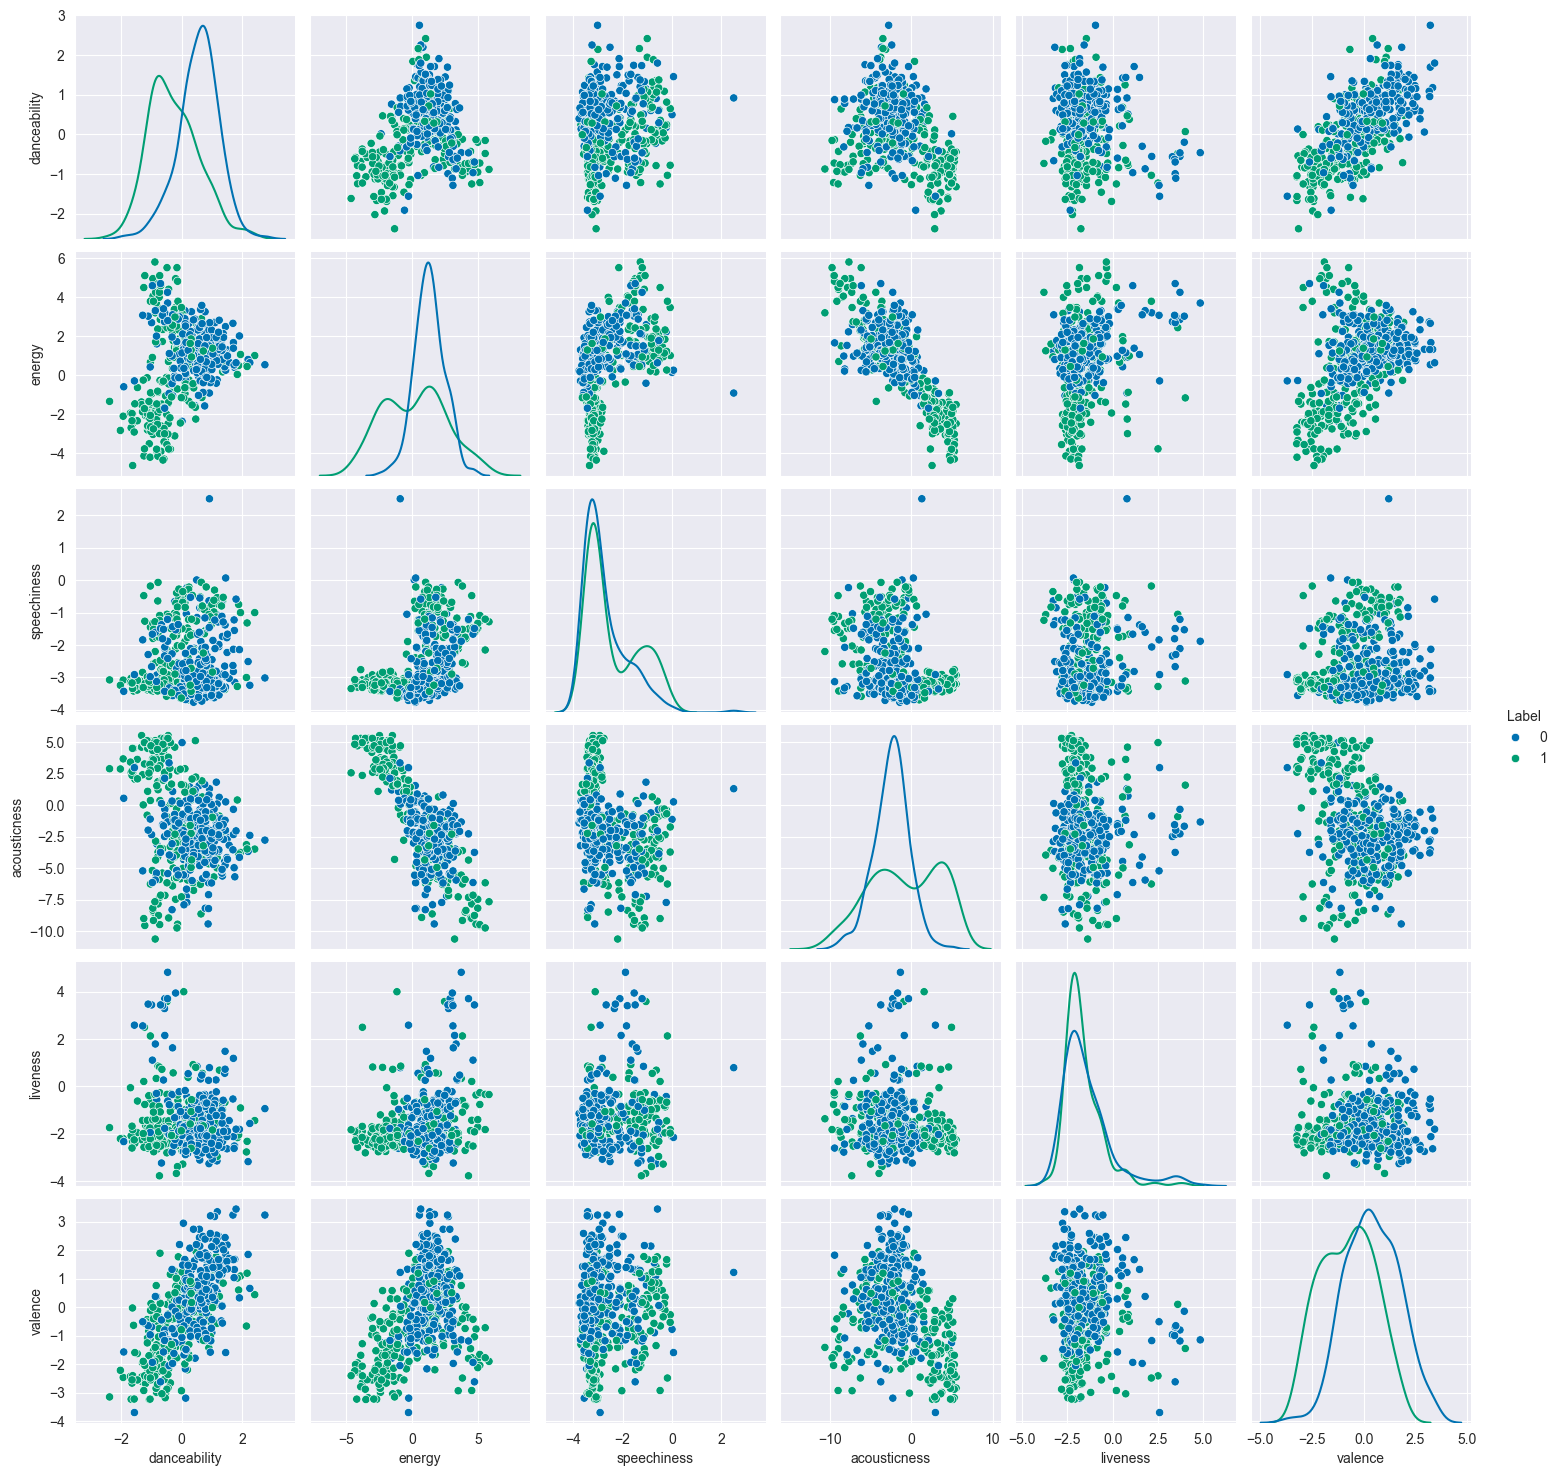

In [19]:
sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label", diag_kws={'fill': False})

     danceability    energy  key  loudness  mode  speechiness  acousticness  \
0        0.033405  0.659874    5  0.565430     0     2.029560      0.210157   
1        1.403912 -0.293480    7  0.093773     1     1.923816     -1.117041   
2       -0.228478  0.597513    5  0.421931     1     2.111205     -1.211603   
3        0.005209  0.954212    4  0.988878     0     1.534864     -1.609214   
4        2.640619  0.136485   11  0.843828     0     1.571069     -0.535230   
..            ...       ...  ...       ...   ...          ...           ...   
498      2.347640 -0.151671   11 -0.235513     1     1.249127     -0.532233   
499      0.971319 -0.481540    0 -0.065231     1    -1.005656      0.480456   
500      0.156410  0.456468    0  0.453084     1    -0.688098      0.002116   
501      0.208971  0.100135   10 -0.127395     0     1.366358     -0.780619   
502      0.794650 -0.440102    9  0.303805     1    -0.762890      0.586460   

     instrumentalness  liveness   valence     tempo

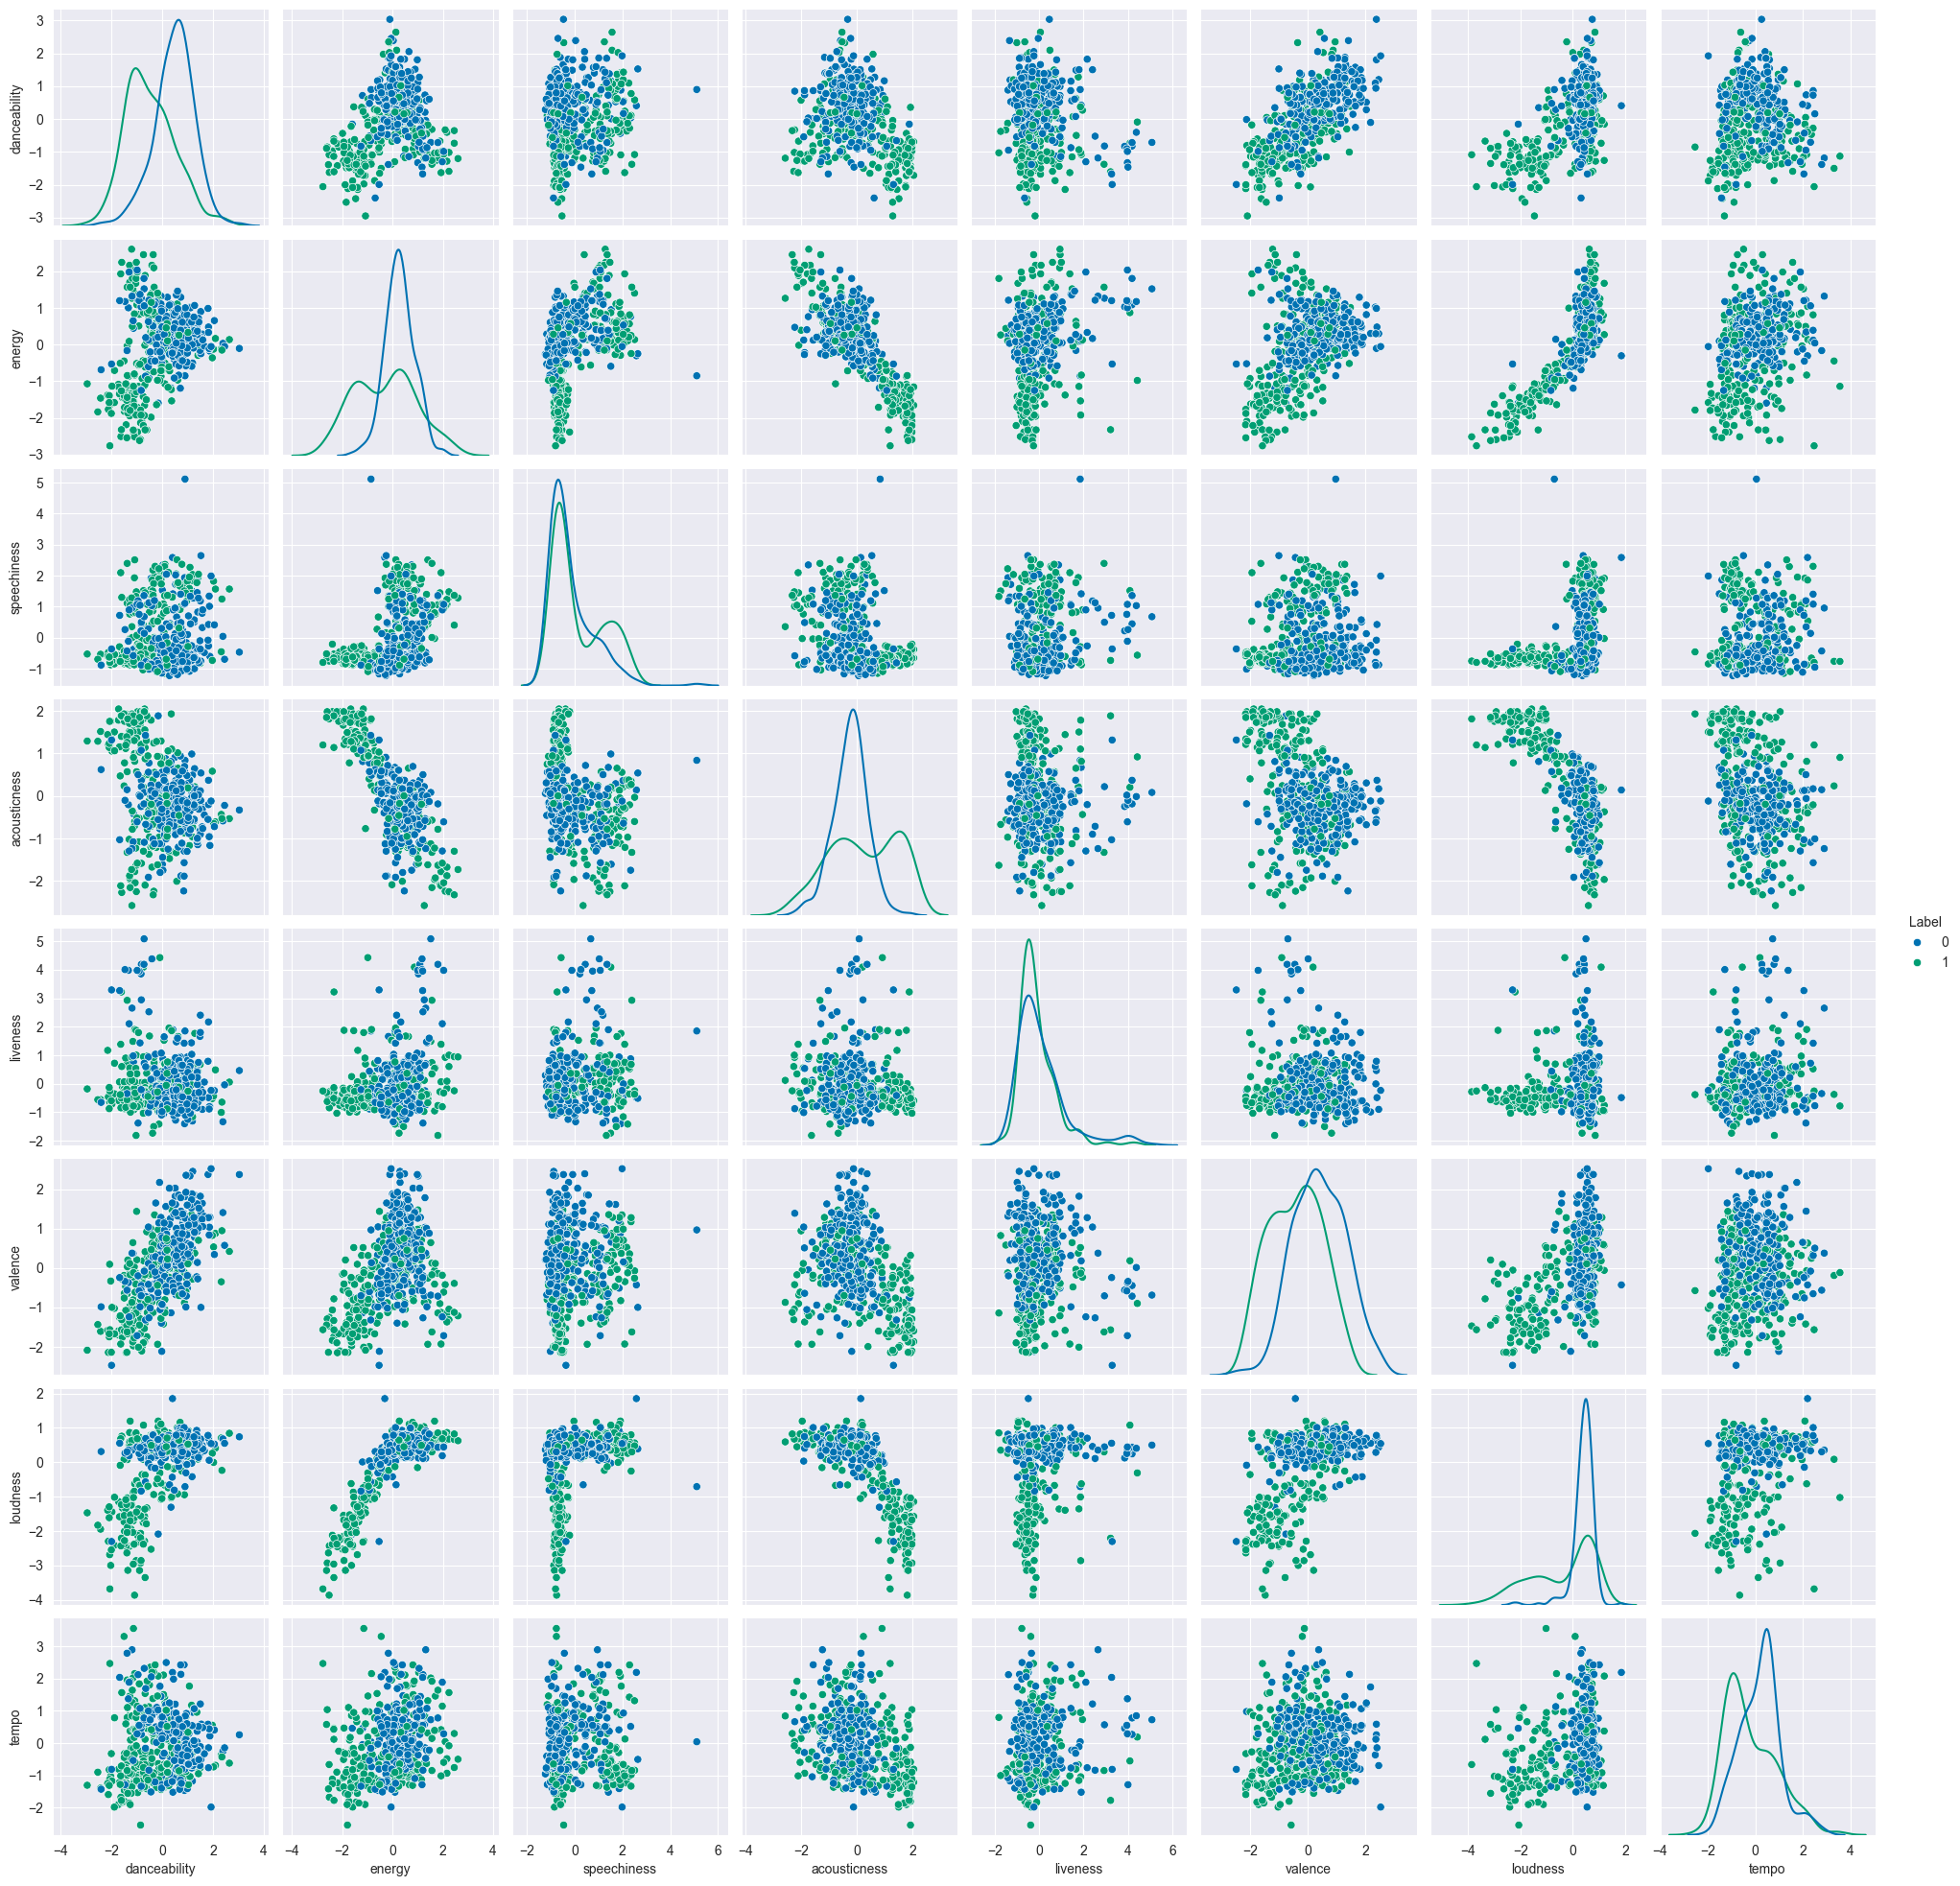

In [53]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label", diag_kws={'fill': False})

In [97]:
all_predictors = scaled_data.drop([] + ["Label"], axis=1)
response = scaled_data["Label"]

# We drop_first because one of the variables in each of key,
# mode is determined by the values of the others
# (for example mode != 0 implies mode = 1)
encoded_data = pd.get_dummies(
    all_predictors, columns=["key", "mode"], drop_first=True
)
print(encoded_data)

predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.2, random_state=0)

     danceability    energy  loudness  speechiness  acousticness  \
0        0.033405  0.659874  0.565430     2.029560      0.210157   
1        1.403912 -0.293480  0.093773     1.923816     -1.117041   
2       -0.228478  0.597513  0.421931     2.111205     -1.211603   
3        0.005209  0.954212  0.988878     1.534864     -1.609214   
4        2.640619  0.136485  0.843828     1.571069     -0.535230   
..            ...       ...       ...          ...           ...   
498      2.347640 -0.151671 -0.235513     1.249127     -0.532233   
499      0.971319 -0.481540 -0.065231    -1.005656      0.480456   
500      0.156410  0.456468  0.453084    -0.688098      0.002116   
501      0.208971  0.100135 -0.127395     1.366358     -0.780619   
502      0.794650 -0.440102  0.303805    -0.762890      0.586460   

     instrumentalness  liveness   valence     tempo  key_1  ...  key_3  key_4  \
0            0.000000  0.790016  0.518871 -1.022488  False  ...  False  False   
1            0.000000

## Training the SVM
First, a linear SVM is tried

In [98]:
linear_svm = SVC(kernel='linear', random_state=0)
linear_svm.fit(predictors_train, response_train)

SVC(kernel='linear', random_state=0)

In [99]:
# Evaluate Linear SVM
response_pred_linear = linear_svm.predict(predictors_test)
accuracy_linear = accuracy_score(response_test, response_pred_linear)
roc_auc_linear = roc_auc_score(response_test, response_pred_linear)
print(f"Linear SVM Accuracy: {accuracy_linear * 100:.2f}%")
print(f"Linear SVM ROC AUC: {roc_auc_linear:.2f}")
print("Linear SVM Classification Report:")
print(classification_report(response_test, response_pred_linear))

confusion_matrix(response_test, response_pred_linear)

Linear SVM Accuracy: 76.24%
Linear SVM ROC AUC: 0.76
Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        53
           1       0.76      0.73      0.74        48

    accuracy                           0.76       101
   macro avg       0.76      0.76      0.76       101
weighted avg       0.76      0.76      0.76       101



array([[42, 11],
       [13, 35]], dtype=int64)

### <span style="color:red">We see similar results as with linear regression, which is sort of expected.</span>

Now, a non-linear SVM with rbf (radial basis function) kernel:

In [100]:
rbf_svm = SVC(kernel='rbf', random_state=0)
rbf_svm.fit(predictors_train, response_train)

SVC(random_state=0)

In [101]:
# Evaluate Nonlinear SVM
response_pred_rbf = rbf_svm.predict(predictors_test)
accuracy_rbf = accuracy_score(response_test, response_pred_rbf)
roc_auc_rbf = roc_auc_score(response_test, response_pred_rbf)
print(f"Nonlinear SVM (RBF) Accuracy: {accuracy_rbf * 100:.2f}%")
confusion_matrix(response_test, response_pred_rbf)

Nonlinear SVM (RBF) Accuracy: 83.17%


array([[43, 10],
       [ 7, 41]], dtype=int64)

### <span style="color:red">The results show improvement in the 'true negatives' (correctly classified dislikes) by significantly reducing the 'false negatives' (instances where dislikes were incorrectly classified as likes).</span>

## An attempt at feature optimization

In [103]:
# RFE (recursive feature elimination) technique
accuracies = {}
features = {}
for i in range(1, predictors_train.shape[1]+1):
    rfe = RFE(estimator=SVC(kernel='linear'), n_features_to_select=i)  # playing around with the number of features to select
    rfe.fit(predictors_train, response_train)
    
    # Check which features are selected
    selected_features = rfe.support_  # Boolean mask of selected features    
    predictors_train_rfe = predictors_train.loc[:, selected_features]
    predictors_test_rfe = predictors_test.loc[:, selected_features]
    
    # Train again with the reduced feature set
    linear_svm_rfe = SVC(kernel='linear', random_state=0)
    linear_svm_rfe.fit(predictors_train_rfe, response_train)
    response_pred_linear_rfe = linear_svm_rfe.predict(predictors_test_rfe)
    
    # Evaluate the Linear SVM with selected features
    accuracy_linear_rfe = accuracy_score(response_test, response_pred_linear_rfe)
    print(f"Accuracy with {i} features: {accuracy_linear_rfe * 100:.2f}%")
    confusion_matrix(response_test, response_pred_linear_rfe)
    accuracies[i] = accuracy_linear_rfe
    features[i] = predictors_train_rfe.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

Accuracy with 1 features: 73.27%
Accuracy with 2 features: 69.31%
Accuracy with 3 features: 70.30%
Accuracy with 4 features: 74.26%
Accuracy with 5 features: 71.29%
Accuracy with 6 features: 72.28%
Accuracy with 7 features: 72.28%
Accuracy with 8 features: 72.28%
Accuracy with 9 features: 72.28%
Accuracy with 10 features: 74.26%
Accuracy with 11 features: 77.23%
Accuracy with 12 features: 77.23%
Accuracy with 13 features: 75.25%
Accuracy with 14 features: 75.25%
Accuracy with 15 features: 76.24%
Accuracy with 16 features: 75.25%
Accuracy with 17 features: 74.26%
Accuracy with 18 features: 75.25%
Accuracy with 19 features: 74.26%
Accuracy with 20 features: 75.25%
Accuracy with 21 features: 76.24%
The best accuracy is 0.7722772277227723 with 11 features.
The selected features are Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'tempo', 'key_5', 'key_6', 'key_8', 'key_10'],
      dtype='object')


In [106]:
accuracies = {}
features = {}
for i in range(1, predictors_train.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
    sfs.fit(predictors_train, response_train)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train.loc[:, selected_features]
    predictors_test_sfs = predictors_test.loc[:, selected_features]
    
    # Train again with the reduced feature set
    rbf_svm_sfs = SVC(kernel='rbf', random_state=0)
    rbf_svm_sfs.fit(predictors_train_sfs, response_train)
    response_pred_rbf_sfs = rbf_svm_sfs.predict(predictors_test_sfs)
    
    # Evaluate the Linear SVM with selected features
    accuracy_rbf_sfs = accuracy_score(response_test, response_pred_rbf_sfs)
    print(f"Accuracy with {i} features: {accuracy_rbf_sfs * 100:.2f}%")
    confusion_matrix(response_test, response_pred_rbf_sfs)
    
    accuracies[i] = accuracy_rbf_sfs
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')


Accuracy with 1 features: 69.31%
Accuracy with 2 features: 76.24%
Accuracy with 3 features: 81.19%
Accuracy with 4 features: 80.20%
Accuracy with 5 features: 80.20%
Accuracy with 6 features: 80.20%
Accuracy with 7 features: 80.20%
Accuracy with 8 features: 80.20%
Accuracy with 9 features: 82.18%
Accuracy with 10 features: 81.19%
Accuracy with 11 features: 81.19%
Accuracy with 12 features: 82.18%
Accuracy with 13 features: 82.18%
Accuracy with 14 features: 82.18%
Accuracy with 15 features: 81.19%
Accuracy with 16 features: 81.19%
Accuracy with 17 features: 82.18%
Accuracy with 18 features: 82.18%
Accuracy with 19 features: 83.17%
Accuracy with 20 features: 83.17%
The best accuracy is 0.8316831683168316 with 19 features.
The selected features are Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
   

##### <span style="color:red">We can see that the improvement in accuracy by adding more features after i=4 is marginal. However, the false negative (liked sings classified as not liked) score only improves with higher number of features.</span>
Let's look at the model with 4 features

In [109]:
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=4)  # Forward selection process
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

rbf_svm_optimized = SVC(kernel='rbf', random_state=0)
rbf_svm_optimized.fit(predictors_train_sfs, response_train)
response_pred_rbf_optimized = rbf_svm_optimized.predict(predictors_test_sfs)

# Evaluate the Linear SVM with selected features
accuracy_rbf_sfs = accuracy_score(response_test, response_pred_rbf_optimized)
print(f"Accuracy: {accuracy_rbf_sfs * 100:.2f}%")
confusion_matrix(response_test, response_pred_rbf_optimized)

Index(['danceability', 'energy', 'speechiness', 'liveness'], dtype='object')
Accuracy: 80.20%


array([[45,  8],
       [12, 36]], dtype=int64)



Now a model with 9 features (cashing out the additional 2% accuracy):

In [110]:
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=9)  # Forward selection process
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

rbf_svm_optimized = SVC(kernel='rbf', random_state=0)
rbf_svm_optimized.fit(predictors_train_sfs, response_train)
response_pred_rbf_optimized = rbf_svm_optimized.predict(predictors_test_sfs)

# Evaluate the Linear SVM with selected features
accuracy_rbf_sfs = accuracy_score(response_test, response_pred_rbf_optimized)
print(f"Accuracy: {accuracy_rbf_sfs * 100:.2f}%")
confusion_matrix(response_test, response_pred_rbf_optimized)

Index(['danceability', 'energy', 'speechiness', 'liveness', 'key_1', 'key_5',
       'key_8', 'key_10', 'key_11'],
      dtype='object')
Accuracy: 82.18%


array([[45,  8],
       [10, 38]], dtype=int64)